<a href="https://colab.research.google.com/github/KarsonLeperi/TimeSeriesProjects/blob/main/ts_machineLearning_energy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Going through the time series forecasting youtube video (Time Series Forecasting with XGBoost - Use python and machine learning to predict energy consumption). Using machine learning to predict energy data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import xgboost as xgb
import io
from google.colab import files

from sklearn.metrics import mean_squared_error

In [2]:
 uploaded = files.upload()

Saving AEP_hourly.csv to AEP_hourly.csv


In [3]:
df = pd.read_csv(io.BytesIO(uploaded['AEP_hourly.csv']))
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values('Datetime', inplace=True) #The data is not sorted in the csv file (discovered during later analysis). This will clean it up
df = df.set_index('Datetime')
df.head(10)

,AEP_MW
Datetime,
2004-10-01 01:00:00,12379.0
2004-10-01 02:00:00,11935.0
2004-10-01 03:00:00,11692.0
2004-10-01 04:00:00,11597.0
2004-10-01 05:00:00,11681.0
2004-10-01 06:00:00,12280.0
2004-10-01 07:00:00,13692.0
2004-10-01 08:00:00,14618.0
2004-10-01 09:00:00,14903.0


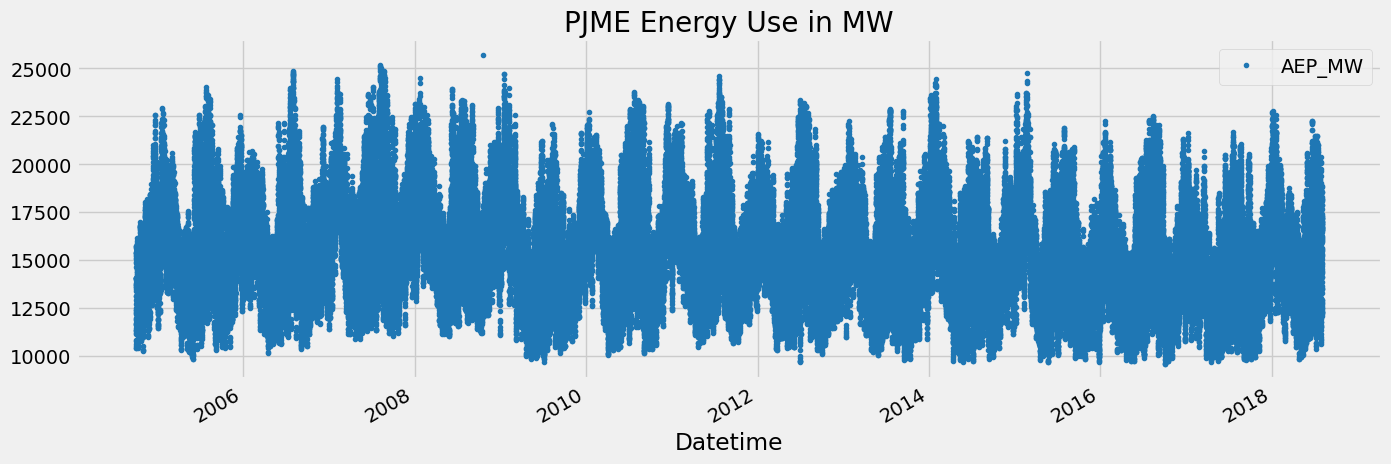

In [4]:
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

df.plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

#Train/Test Split

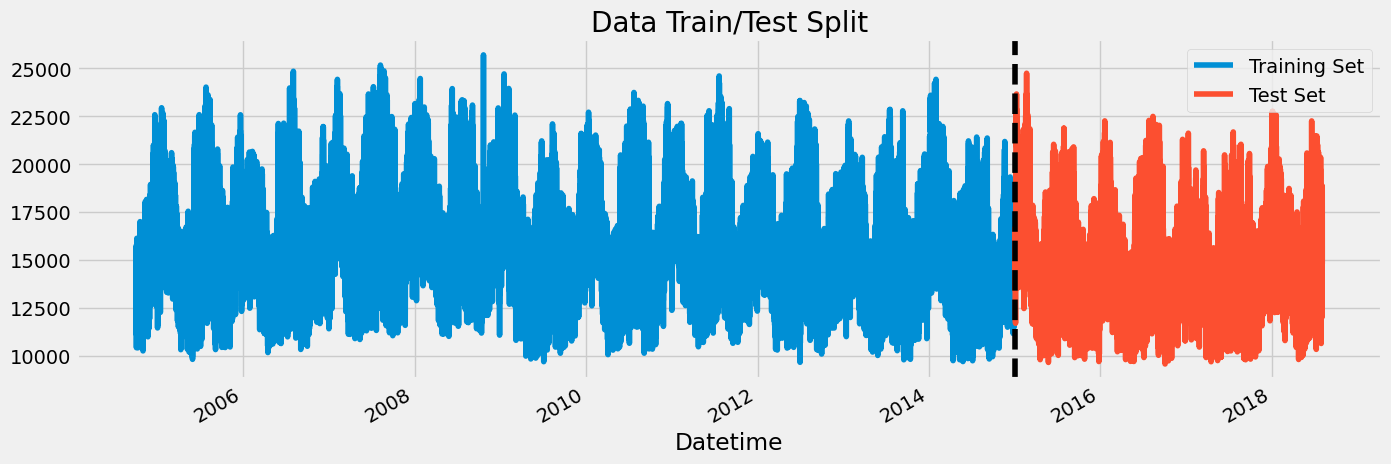

In [5]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

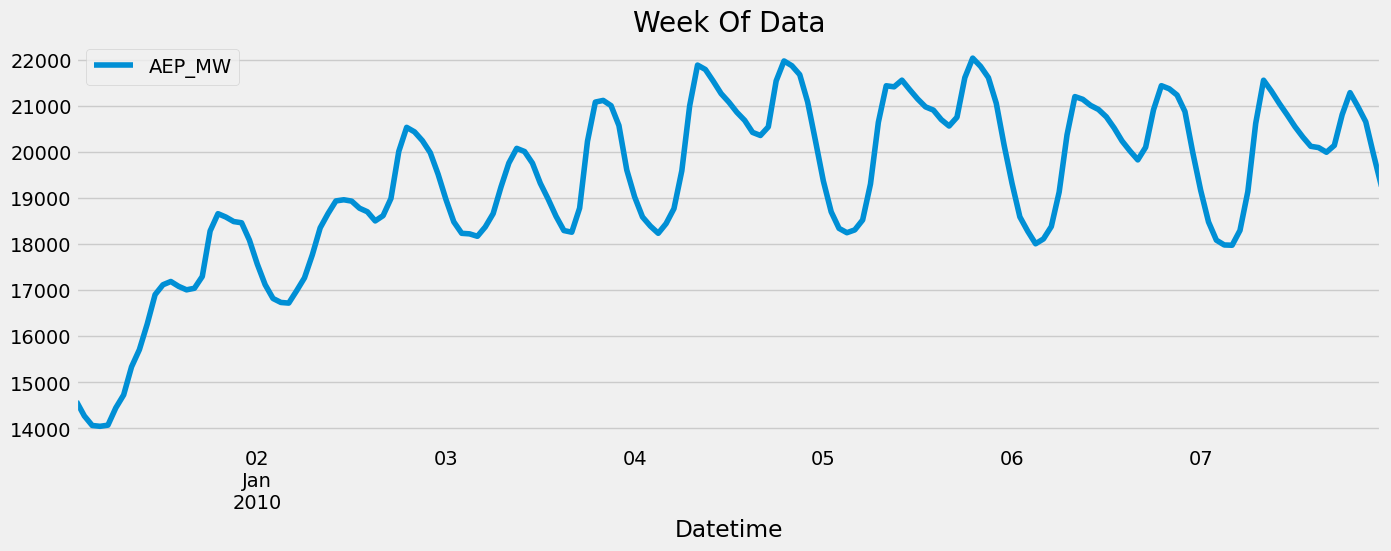

In [6]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')
plt.show()

#Feature Creation

In [7]:
def create_features(df):
  """
  Create time series features based on time series index.
  """
  df = df.copy()

  df['hour'] = df.index.hour
  df['dayofweek'] = df.index.dayofweek
  df['quarter'] = df.index.quarter
  df['month'] = df.index.month
  df['year'] = df.index.year
  df['dayofyear'] = df.index.dayofyear
  df['dayofmonth'] = df.index.day
  df['weekofyear'] = df.index.isocalendar().week

  return df

df = create_features(df)
df.head()


,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,,
2004-10-01 01:00:00,12379.0,1,4,4,10,2004,275,1,40
2004-10-01 02:00:00,11935.0,2,4,4,10,2004,275,1,40
2004-10-01 03:00:00,11692.0,3,4,4,10,2004,275,1,40
2004-10-01 04:00:00,11597.0,4,4,4,10,2004,275,1,40
2004-10-01 05:00:00,11681.0,5,4,4,10,2004,275,1,40


#Visualize Feature

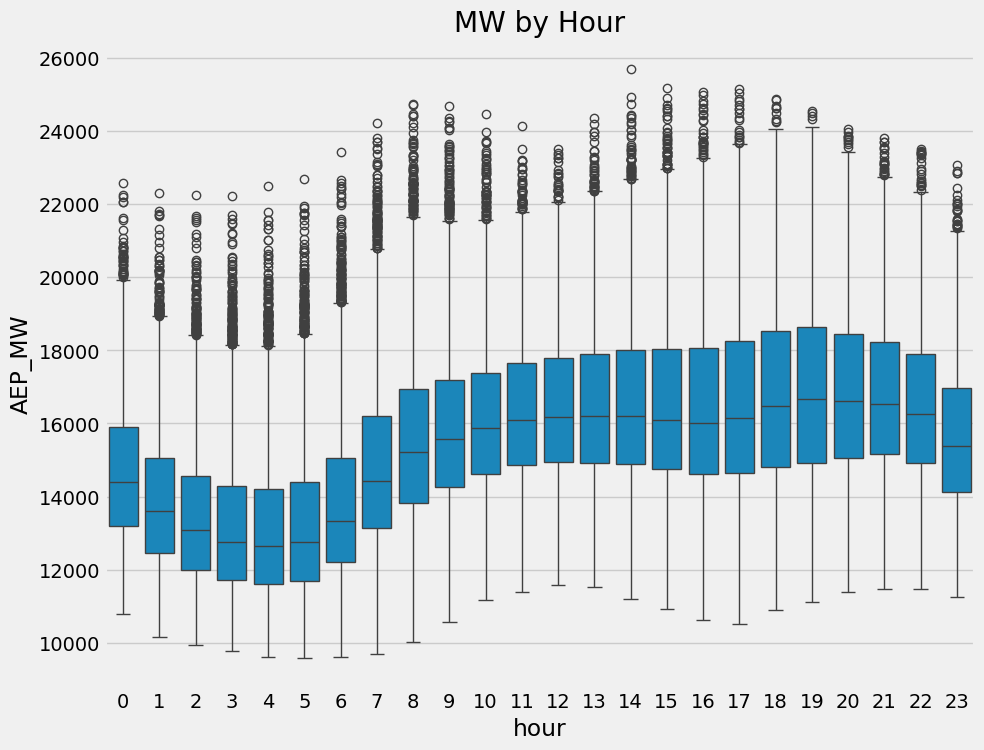

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='AEP_MW')
ax.set_title('MW by Hour')
plt.show()

/tmp/ipython-input-1997979185.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='AEP_MW',palette='Blues')


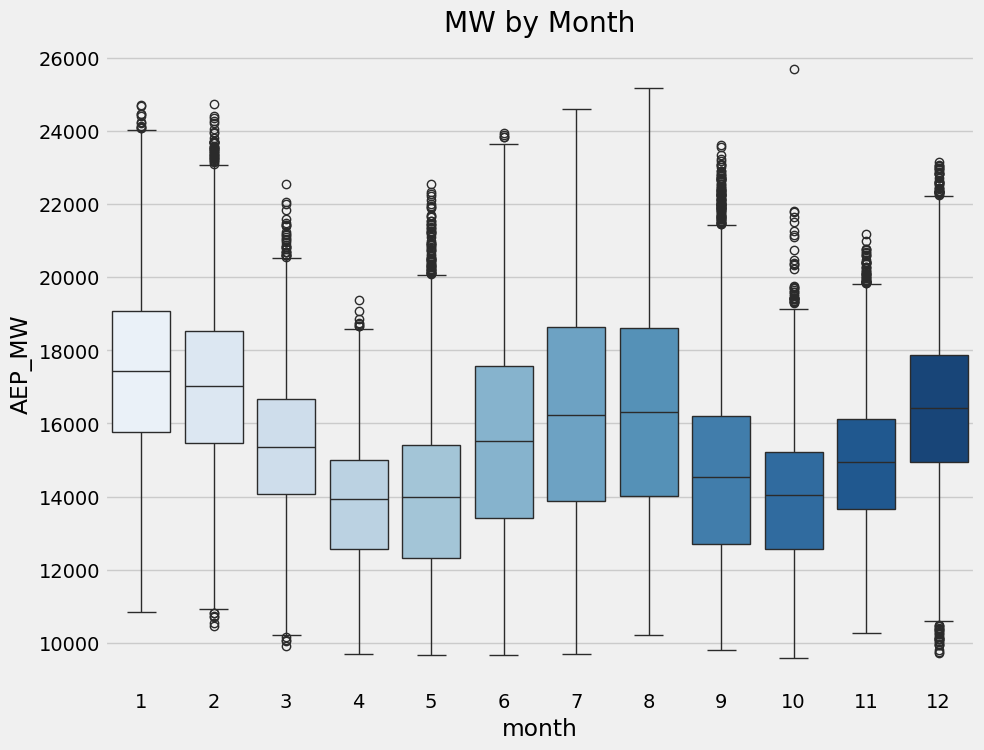

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='AEP_MW',palette='Blues')
ax.set_title('MW by Month')
plt.show()

#Create Model

In [10]:
train = create_features(train)
test = create_features(test)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'AEP_MW'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [11]:
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate = 0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:2557.05852	validation_1-rmse:2669.66874
[100]	validation_0-rmse:1667.99304	validation_1-rmse:1906.43321
[200]	validation_0-rmse:1388.41609	validation_1-rmse:1728.03964
[300]	validation_0-rmse:1260.06288	validation_1-rmse:1670.94367
[400]	validation_0-rmse:1170.54347	validation_1-rmse:1651.32523
[500]	validation_0-rmse:1113.48343	validation_1-rmse:1643.19503
[544]	validation_0-rmse:1091.83993	validation_1-rmse:1645.76653


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

#Feature Importance

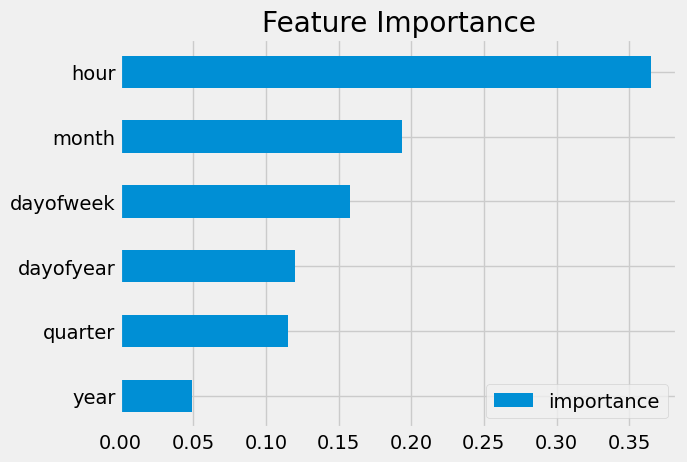

In [12]:
fi = pd.DataFrame(reg.feature_importances_,
             index = reg.feature_names_in_,
             columns=['importance']).sort_values('importance')

fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

As expected, the most important features are hour, month, and day of week. Day of year and quarter are probably excess variables that couold be infered from the first three variables.

#Forecast on Test

In [13]:
test['prediction'] = reg.predict(X_test)
test.head()


,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2015-01-01 00:00:00,16375.0,0,3,1,1,2015,1,1,1,16409.544922
2015-01-01 01:00:00,16172.0,1,3,1,1,2015,1,1,1,15945.625000
2015-01-01 02:00:00,15968.0,2,3,1,1,2015,1,1,1,15893.853516
2015-01-01 03:00:00,15749.0,3,3,1,1,2015,1,1,1,15935.795898
2015-01-01 04:00:00,15727.0,4,3,1,1,2015,1,1,1,15935.795898


In [14]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
df.tail()

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2018-08-02 20:00:00,17673.0,20,3,3,8,2018,214,2,31,18112.775391
2018-08-02 21:00:00,17303.0,21,3,3,8,2018,214,2,31,18112.775391
2018-08-02 22:00:00,17001.0,22,3,3,8,2018,214,2,31,17780.941406
2018-08-02 23:00:00,15964.0,23,3,3,8,2018,214,2,31,16259.825195
2018-08-03 00:00:00,14809.0,0,4,3,8,2018,215,3,31,14421.719727


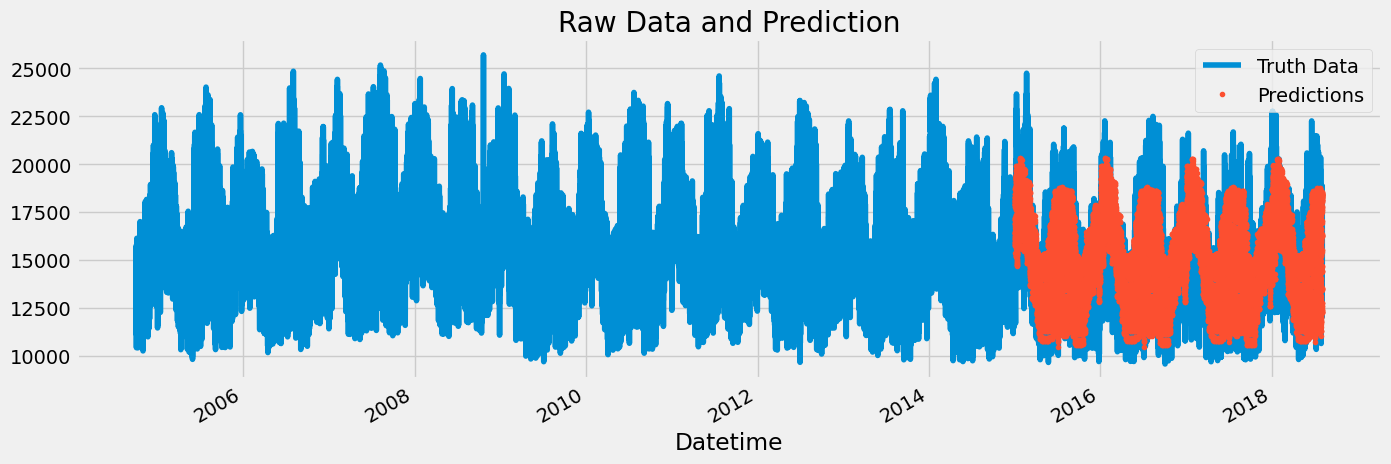

In [16]:
ax = df[['AEP_MW']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

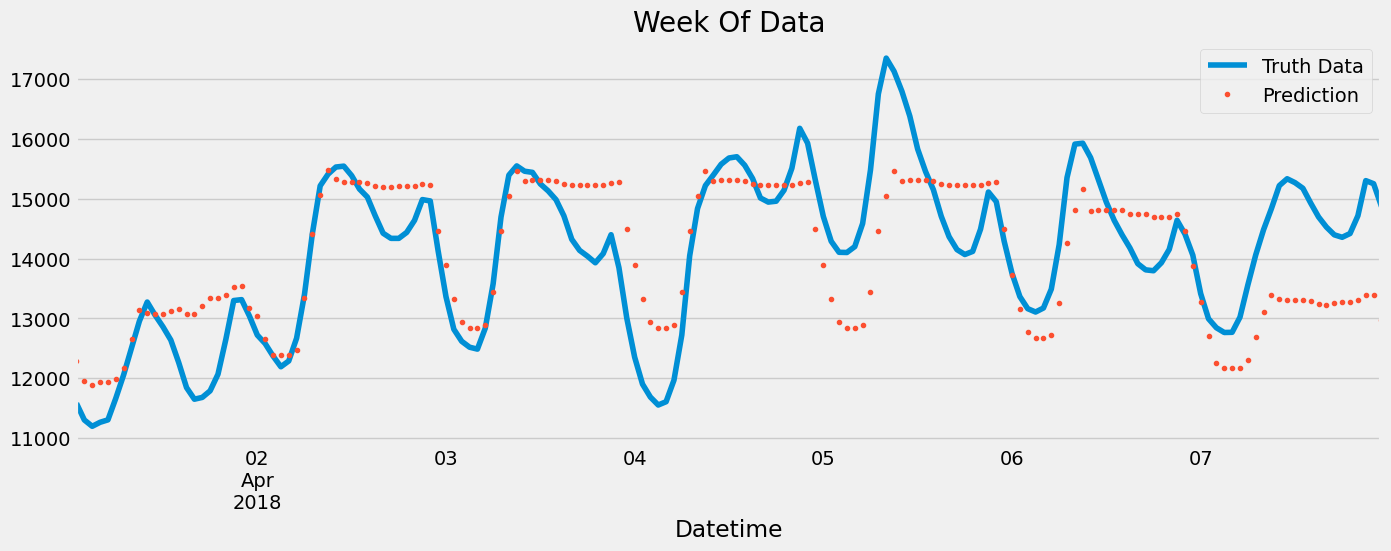

In [ ]:

ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['AEP_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 1643.09


Aggregate the energy usage error by date and report the most inaccurate dates.

In [17]:
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

,error
date,
2017-01-22,4872.108968
2015-02-20,4861.401571
2015-02-19,4769.359985
2018-01-06,4403.549683
2017-02-07,4290.881022
2018-01-07,4202.593099
2017-01-03,4168.695475
2016-02-03,4092.213298
2017-01-23,4076.364746


At this point, I will begin exploring on my own. All of the worse performing points are in the January and February. Lets look at January and February of 2017 which contains 5 of the data points.

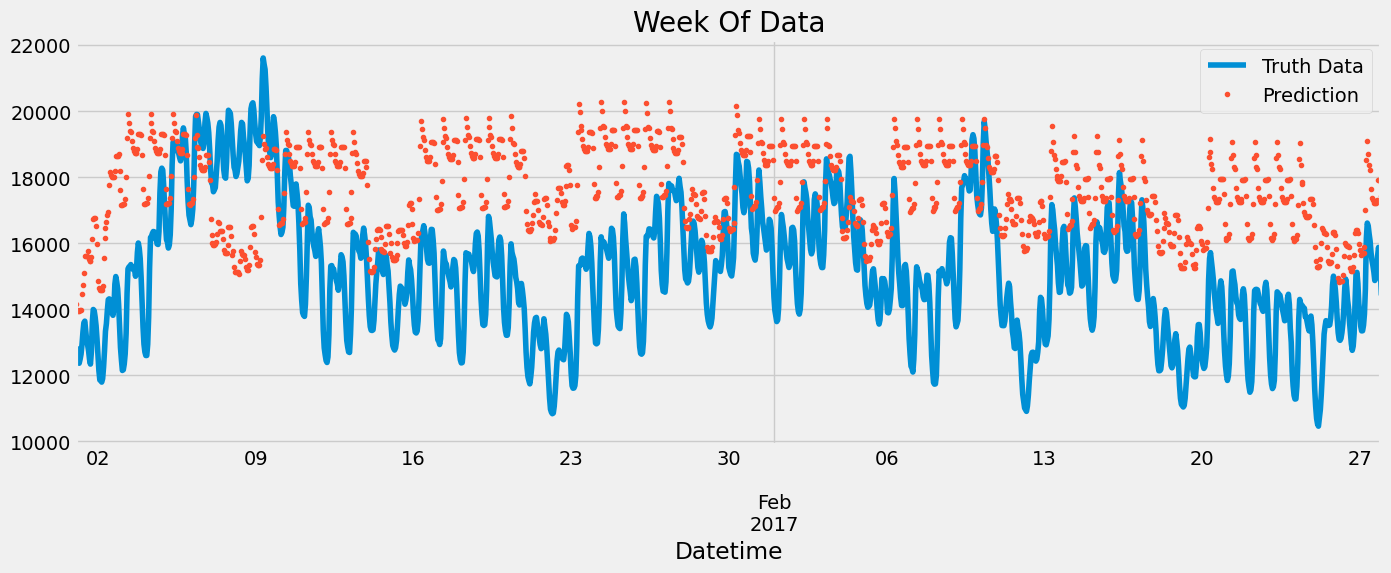

In [18]:
ax = df.loc[(df.index > '01-01-2017') & (df.index < '02-28-2017')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')
df.loc[(df.index > '01-01-2017') & (df.index < '02-28-2017')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()

Hmm, it looks like most of the errors are overpredictions (predicting higher energy usage than expected). Seeing that AEP is the electric utility for Ohio, I would hypothesize a significant amount of the energy usage for January and February would be related to heating homes. If there is unseasonably warm weather in January and February, we would possibly see a reduction in energy usage that would not be accruately preducted. I seem to remember (I was living in Chicago at the time) that the 2017 winter was relatively mild compared to other years.

Looking at the weather data (weather.gov) from January 2017 for Columbus, OH, the average high in January 2017 was 7 degrees greater than normal. The average low was 8 degrees greater than normal. Diving into the data further, we can see that on January 22, 2017 (highest error), the daily high was 64 deg F, 27 deg above normal. This would seem to confirm my hypothesis that the error is due to abnormally hot weather in the winter.

In terms of improving the prediction, the easiest addition would be to add a variable incorporating weather data. Based off of the exploration above, a variable tracking the difference between the expected high and the average high for the data would supply the most information.

## Part 2 follow up

There was a follow up youtube video where some of the most replied suggestions were implemented. I shall do the same. Time Series Forecasting with XGBoost - Advanced Methods https://www.youtube.com/watch?v=z3ZnOW-S550&list=WL&index=13

### 1) Outlier removal

<Axes: ylabel='Frequency'>

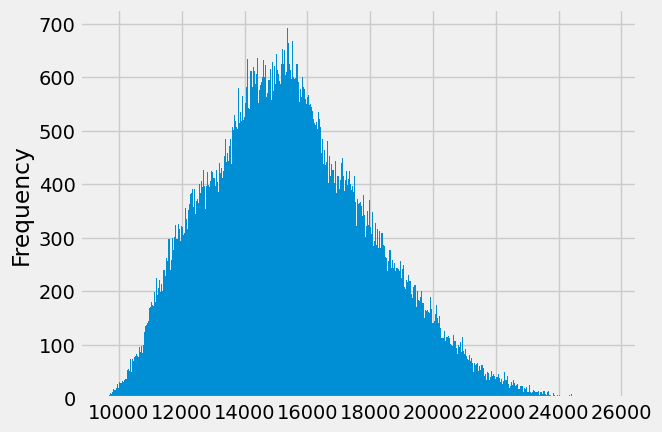

In [21]:
df['AEP_MW'].plot(kind='hist', bins=500)

In [31]:
df.query('AEP_MW > 25000')

,AEP_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,prediction
Datetime,,,,,,,,,,
2007-08-08 15:00:00,25164.0,15,2,3,8,2007,220,8,32,NaN
2007-08-08 16:00:00,25056.0,16,2,3,8,2007,220,8,32,NaN
2007-08-08 17:00:00,25140.0,17,2,3,8,2007,220,8,32,NaN
2007-08-09 17:00:00,25035.0,17,3,3,8,2007,221,9,32,NaN
2008-10-20 14:00:00,25695.0,14,0,4,10,2008,294,20,43,NaN


Looking at the histogram, we can see the data has a bell curve shape. However, looking back at the full plot, we can see there seems to be one data point in 2009 ish that is much higher than the surrounding data points. Looking at the month box plot, we can see this same data point might be in October of 2009. Let's look at October of 2008.

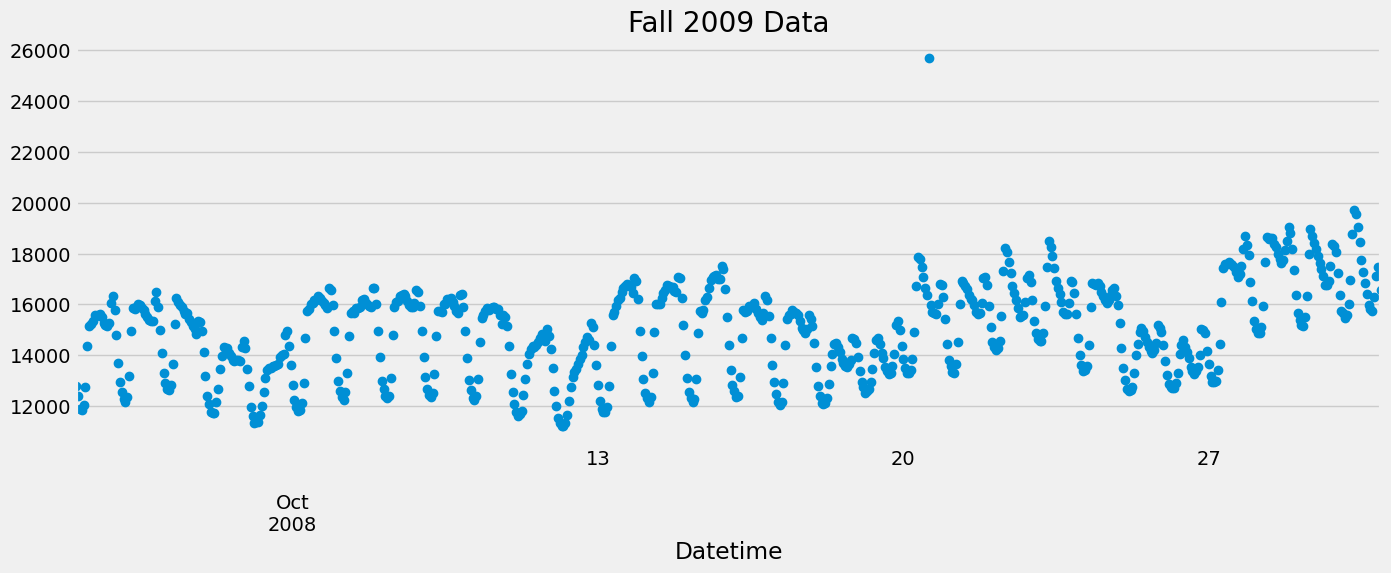

In [27]:
ax = df.loc[(df.index > '10-01-2008') & (df.index < '10-31-2008')]['AEP_MW'] \
    .plot(figsize=(15, 5), title='Fall 2009 Data', marker = 'o', linestyle='')
plt.show()

Let's remove that data point which is 33% + larger than the surrounding data. Besides that, all the other outliers seem to be around the same date range, so I will keep them.

In [32]:
df = df.query('AEP_MW < 25_500').copy()

###2) Time Series Cross-Validation

In [33]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

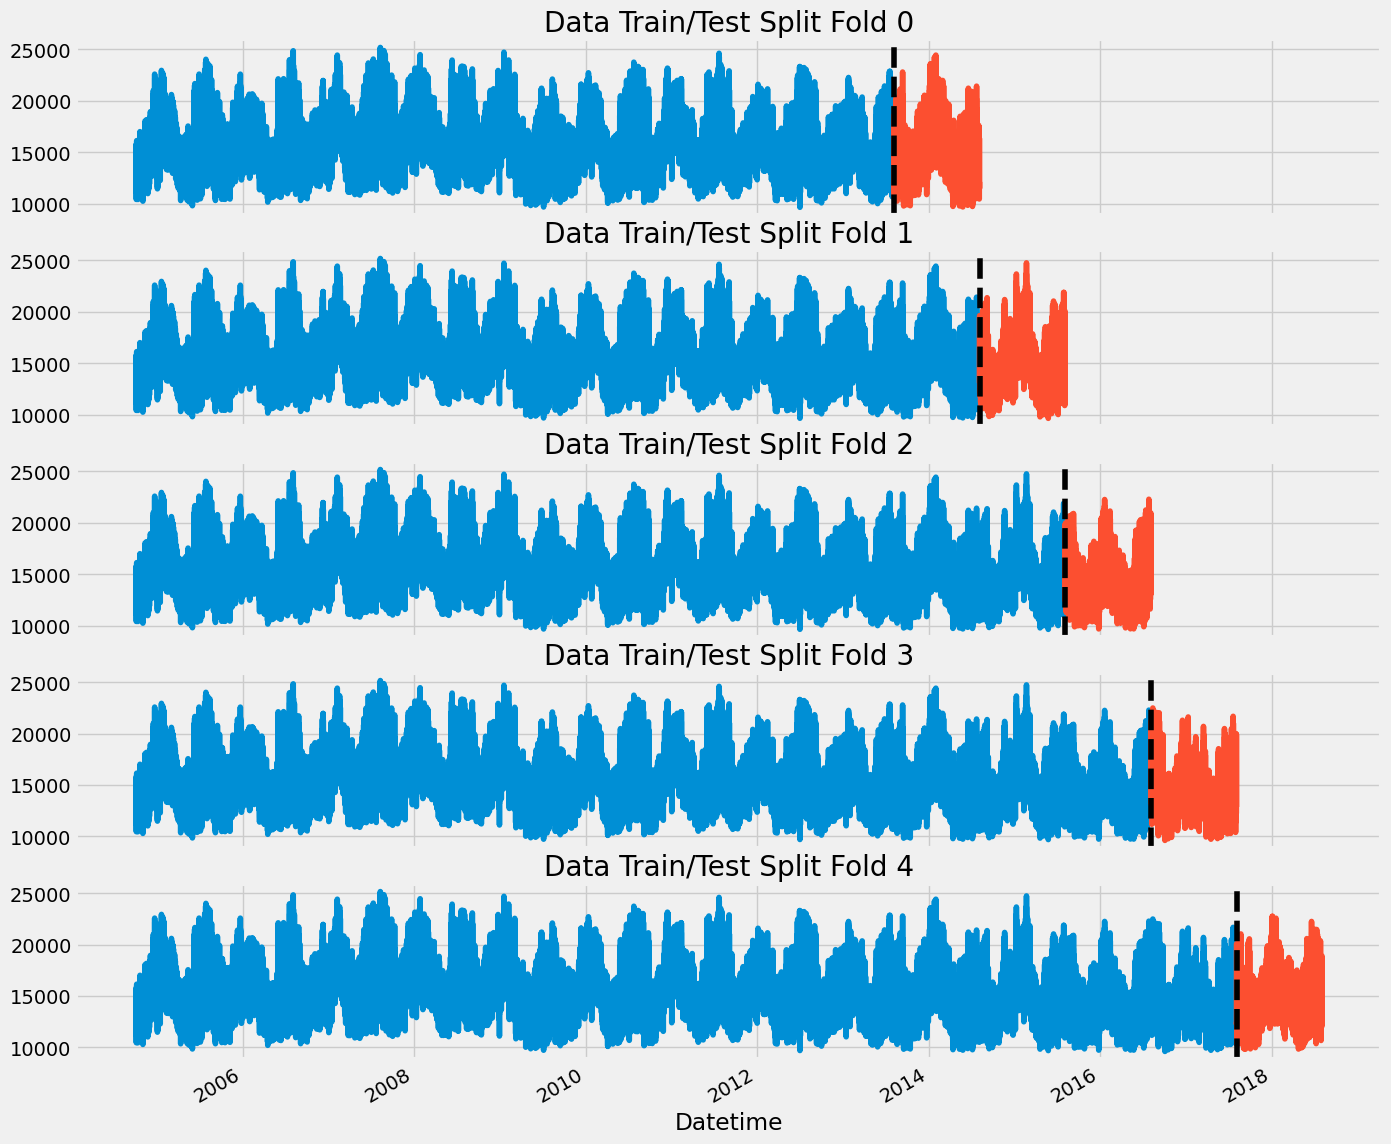

In [34]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['AEP_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AEP_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

### 3) Lag Features

In [37]:
def add_lags(df):
    target_map = df['AEP_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [38]:
df = add_lags(df)

Training

In [40]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'AEP_MW'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:squarederror',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:15898.03113	validation_1-rmse:15263.64389
[100]	validation_0-rmse:6031.10029	validation_1-rmse:5645.59194
[200]	validation_0-rmse:2653.98825	validation_1-rmse:2426.91728
[300]	validation_0-rmse:1707.08329	validation_1-rmse:1644.72726
[400]	validation_0-rmse:1489.80648	validation_1-rmse:1551.11461
[463]	validation_0-rmse:1445.97394	validation_1-rmse:1554.49916
[0]	validation_0-rmse:15834.99651	validation_1-rmse:15222.40367
[100]	validation_0-rmse:6007.58253	validation_1-rmse:5715.60355
[200]	validation_0-rmse:2645.16579	validation_1-rmse:2504.38734
[300]	validation_0-rmse:1707.50979	validation_1-rmse:1616.55439
[400]	validation_0-rmse:1500.85941	validation_1-rmse:1452.26766
[500]	validation_0-rmse:1442.28701	validation_1-rmse:1428.93763
[600]	validation_0-rmse:1410.76972	validation_1-rmse:1428.32590
[627]	validation_0-rmse:1404.56989	validation_1-rmse:1428.86707
[0]	validation_0-rmse:15778.90821	validation_1-rmse:14549.79005
[100]	validation_0-rmse:5985.23715	valid

In [41]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 1564.0351
Fold scores:[np.float64(1550.4603694031152), np.float64(1427.667855316764), np.float64(1499.9665274669187), np.float64(1645.4343196934153), np.float64(1696.646615156534)]


###4) Future Prediction

In [43]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'AEP_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:squarederror',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:15558.69835
[100]	validation_0-rmse:5908.65263
[200]	validation_0-rmse:2622.39482
[300]	validation_0-rmse:1721.87521
[400]	validation_0-rmse:1523.74705
[499]	validation_0-rmse:1472.30123


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [44]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [45]:
# Create future dataframe
future = pd.date_range('2018-08-03','2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [46]:
future_w_features = df_and_future.query('isFuture').copy()

Prediction

In [47]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

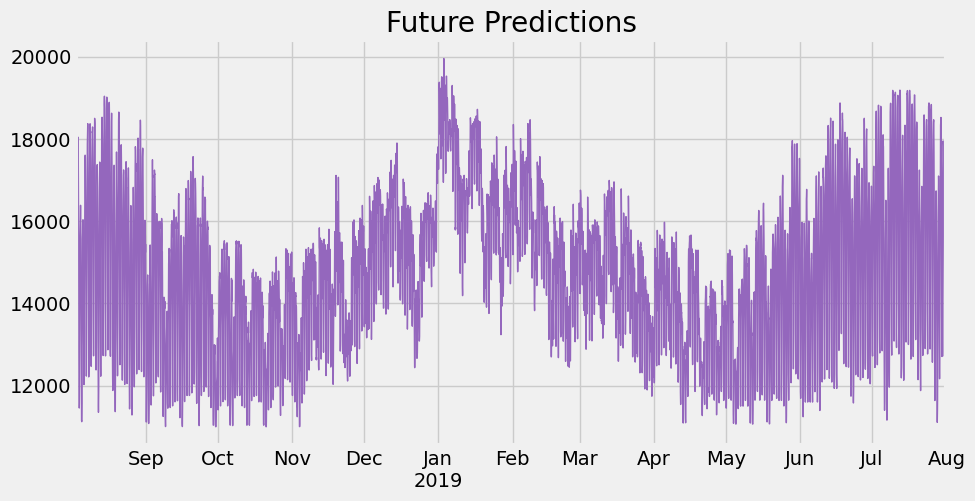

In [48]:
future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[4],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

<Axes: title={'center': 'New year Data'}>

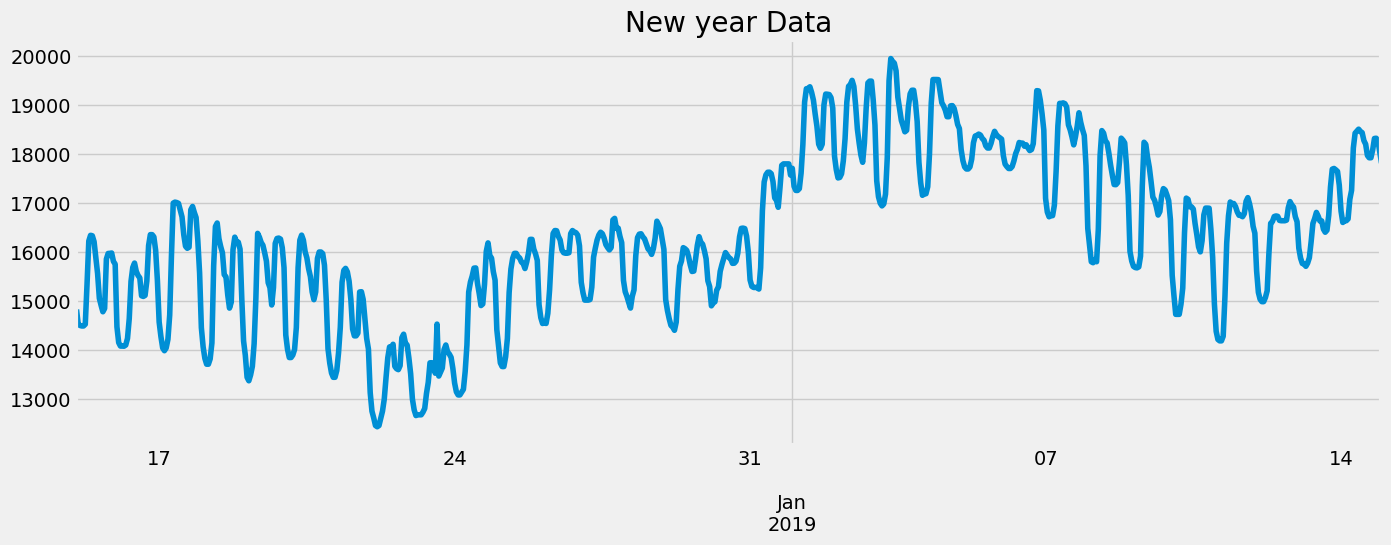

In [52]:
future_w_features['pred'].loc[(future_w_features.index > '12-15-2018') & (future_w_features.index < '01-15-2019')] \
    .plot(figsize=(15, 5), title='New year Data')